In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
!pip install yfinance --upgrade --no-cache-dir
from pandas_datareader import data as pdr
import yfinance as yf
from collections import deque
import random
import tensorflow.compat.v1 as tf
tf.compat.v1.disable_eager_execution()

In [2]:
yf.pdr_override()
df_full = pdr.get_data_yahoo("INFY", start="2018-01-01").reset_index()
df_full.to_csv('INFY.csv',index=False)
df_full.head()

[*********************100%***********************]  1 of 1 completed


,Date,Open,High,Low,Close,Adj Close,Volume
0,2018-01-02,8.135,8.195,8.115,8.145,7.130623,12298200
1,2018-01-03,8.120,8.135,8.050,8.075,7.069340,10250800
2,2018-01-04,8.100,8.100,8.010,8.025,7.025568,16272000
3,2018-01-05,8.085,8.190,8.075,8.175,7.156887,9813600
4,2018-01-08,8.190,8.260,8.170,8.240,7.213791,11198200


In [5]:
df= df_full.copy()
name = 'Q-learning agent'
class Agent:
    def __init__(self, state_size, window_size, trend, skip, batch_size):
        self.state_size = state_size
        self.window_size = window_size
        self.half_window = window_size // 2
        self.trend = trend
        self.skip = skip
        self.action_size = 3
        self.batch_size = batch_size
        self.memory = deque(maxlen = 1000)
        self.inventory = []
        self.gamma = 0.95
        self.epsilon = 0.5
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.999
        tf.reset_default_graph()
        self.sess = tf.InteractiveSession()
        self.X = tf.placeholder(tf.float32, [None, self.state_size])
        self.Y = tf.placeholder(tf.float32, [None, self.action_size])
        feed = tf.layers.dense(self.X, 256, activation = tf.nn.relu)
        self.logits = tf.layers.dense(feed, self.action_size)
        self.cost = tf.reduce_mean(tf.square(self.Y - self.logits))
        self.optimizer = tf.train.GradientDescentOptimizer(1e-5).minimize(
            self.cost
        )
        self.sess.run(tf.global_variables_initializer())
    def act(self, state):
        if random.random() <= self.epsilon:
            return random.randrange(self.action_size)
        return np.argmax(
            self.sess.run(self.logits, feed_dict = {self.X: state})[0]
        )
    def get_state(self, t):
        window_size = self.window_size + 1
        d = t - window_size + 1
        block = self.trend[d : t + 1] if d >= 0 else -d * [self.trend[0]] + self.trend[0 : t + 1]
        res = []
        for i in range(window_size - 1):
            res.append(block[i + 1] - block[i])
        return np.array([res])
    def replay(self, batch_size):
        mini_batch = []
        l = len(self.memory)
        for i in range(l - batch_size, l):
            mini_batch.append(self.memory[i])
        replay_size = len(mini_batch)
        X = np.empty((replay_size, self.state_size))
        Y = np.empty((replay_size, self.action_size))
        states = np.array([a[0][0] for a in mini_batch])
        new_states = np.array([a[3][0] for a in mini_batch])
        Q = self.sess.run(self.logits, feed_dict = {self.X: states})
        Q_new = self.sess.run(self.logits, feed_dict = {self.X: new_states})
        for i in range(len(mini_batch)):
            state, action, reward, next_state, done = mini_batch[i]
            target = Q[i]
            target[action] = reward
            if not done:
                target[action] += self.gamma * np.amax(Q_new[i])
            X[i] = state
            Y[i] = target
        cost, _ = self.sess.run(
            [self.cost, self.optimizer], feed_dict = {self.X: X, self.Y: Y}
        )
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay
        return cost
    # def buy(self, initial_money):
    #     starting_money = initial_money
    #     states_sell = []
    #     states_buy = []
    #     inventory = []
    #     state = self.get_state(0)
    #     for t in range(0, len(self.trend) - 1, self.skip):
    #         action = self.act(state)
    #         next_state = self.get_state(t + 1)
    #         if action == 1 and initial_money >= self.trend[t] and t < (len(self.trend) - self.half_window):
    #             inventory.append(self.trend[t])
    #             initial_money -= self.trend[t]
    #             states_buy.append(t)
    #             print('day %d: buy 1 unit at price %f, total balance %f'% (t, self.trend[t], initial_money))
    #         elif action == 2 and len(inventory):
    #             bought_price = inventory.pop(0)
    #             initial_money += self.trend[t]
    #             states_sell.append(t)
    #             try:
    #                 invest = ((close[t] - bought_price) / bought_price) * 100
    #             except:
    #                 invest = 0
    #             print(
    #                 'day %d, sell 1 unit at price %f, investment %f %%, total balance %f,'
    #                 % (t, close[t], invest, initial_money)
    #             )
    #         state = next_state
    #     invest = ((initial_money - starting_money) / starting_money) * 100
    #     total_gains = initial_money - starting_money
    #     return states_buy, states_sell, total_gains, invest
    def buy(self, initial_money):
        starting_money = initial_money
        states_sell = []
        states_buy = []
        inventory = []
        trades = []
        state = self.get_state(0)
        for t in range(0, len(self.trend) - 1, self.skip):
            action = self.act(state)
            next_state = self.get_state(t + 1)
            if action == 1 and initial_money >= self.trend[t] and t < (len(self.trend) - self.half_window):
                inventory.append(self.trend[t])
                initial_money -= self.trend[t]
                states_buy.append(t)
                trades.append(('buy', self.trend[t], t))
                print('day %d: buy 1 unit at price %f, total balance %f'% (t, self.trend[t], initial_money))
            elif action == 2 and len(inventory):
                bought_price = inventory.pop(0)
                initial_money += self.trend[t]
                states_sell.append(t)
                try:
                    invest = ((close[t] - bought_price) / bought_price) * 100
                except:
                    invest = 0
                trades.append(('sell', close[t], t, invest))
                print(
                    'day %d, sell 1 unit at price %f, investment %f %%, total balance %f,'
                    % (t, close[t], invest, initial_money)
                )
            state = next_state
        invest = ((initial_money - starting_money) / starting_money) * 100
        total_gains = initial_money - starting_money
        return states_buy, states_sell, trades, total_gains, invest
    def train(self, iterations, checkpoint, initial_money):
        for i in range(iterations):
            total_profit = 0
            inventory = []
            state = self.get_state(0)
            starting_money = initial_money
            for t in range(0, len(self.trend) - 1, self.skip):
                action = self.act(state)
                next_state = self.get_state(t + 1)
                if action == 1 and starting_money >= self.trend[t] and t < (len(self.trend) - self.half_window):
                    inventory.append(self.trend[t])
                    starting_money -= self.trend[t]
                elif action == 2 and len(inventory) > 0:
                    bought_price = inventory.pop(0)
                    total_profit += self.trend[t] - bought_price
                    starting_money += self.trend[t]
                invest = ((starting_money - initial_money) / initial_money)
                self.memory.append((state, action, invest, 
                                    next_state, starting_money < initial_money))
                state = next_state
                batch_size = min(self.batch_size, len(self.memory))
                cost = self.replay(batch_size)
            if (i+1) % checkpoint == 0:
                print('epoch: %d, total rewards: %f.3, cost: %f, total money: %f'%(i + 1, total_profit, cost,
                                                                                  starting_money))

In [6]:
close = df.Close.values.tolist()
initial_money = 10000
window_size = 30
skip = 1
batch_size = 32
agent = Agent(state_size = window_size, 
              window_size = window_size, 
              trend = close, 
              skip = skip, 
              batch_size = batch_size)
agent.train(iterations = 200, checkpoint = 10, initial_money = initial_money)

C:\Users\austi\AppData\Local\Temp\ipykernel_30704\625882402.py:22: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  feed = tf.layers.dense(self.X, 256, activation = tf.nn.relu)
C:\Users\austi\AppData\Local\Temp\ipykernel_30704\625882402.py:23: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  self.logits = tf.layers.dense(feed, self.action_size)


epoch: 10, total rewards: 19.070030.3, cost: 0.003321, total money: 10019.070030
epoch: 20, total rewards: 3.635030.3, cost: 0.002663, total money: 10003.635030
epoch: 30, total rewards: 7.675026.3, cost: 0.002651, total money: 10007.675026
epoch: 40, total rewards: 10.805021.3, cost: 0.002638, total money: 10010.805021
epoch: 50, total rewards: 9.895018.3, cost: 0.002626, total money: 10009.895018
epoch: 60, total rewards: 16.180017.3, cost: 0.002616, total money: 10016.180017
epoch: 70, total rewards: 9.845015.3, cost: 0.002603, total money: 10009.845015
epoch: 80, total rewards: 4.060019.3, cost: 0.002592, total money: 10004.060019
epoch: 90, total rewards: 4.880015.3, cost: 0.002582, total money: 10004.880015
epoch: 100, total rewards: 14.750018.3, cost: 0.002574, total money: 10014.750018
epoch: 110, total rewards: 10.555019.3, cost: 0.002564, total money: 10010.555019
epoch: 120, total rewards: 9.130018.3, cost: 0.002555, total money: 10009.130018
epoch: 130, total rewards: 13.57

In [11]:
states_buy, states_sell, trades, total_gains, invest = agent.buy(initial_money)

print("----- Trades -----")
for trade in trades:
    if trade[0] == 'buy':
        print("Bought 1 unit at price %f on day %d." % (trade[1], trade[2]))
    else:
        print("Sold 1 unit at price %f on day %d, investment %f %%." % (trade[1], trade[2], trade[3]))

day 6: buy 1 unit at price 8.495000, total balance 9991.505000
day 7: buy 1 unit at price 8.635000, total balance 9982.870000
day 9: buy 1 unit at price 8.890000, total balance 9973.980000
day 10, sell 1 unit at price 9.060000, investment 6.650978 %, total balance 9983.040000,
day 11: buy 1 unit at price 8.960000, total balance 9974.080000
day 13: buy 1 unit at price 9.145000, total balance 9964.934999
day 15: buy 1 unit at price 9.230000, total balance 9955.705000
day 16, sell 1 unit at price 9.225000, investment 6.832659 %, total balance 9964.930000,
day 17, sell 1 unit at price 9.250000, investment 4.049490 %, total balance 9974.180000,
day 19: buy 1 unit at price 9.125000, total balance 9965.055000
day 20, sell 1 unit at price 9.005000, investment 0.502233 %, total balance 9974.060000,
day 21, sell 1 unit at price 8.965000, investment -1.968292 %, total balance 9983.025001,
day 22, sell 1 unit at price 8.875000, investment -3.846149 %, total balance 9991.900001,
day 24, sell 1 unit

In [8]:
states_buy, states_sell, total_gains, invest = agent.buy(initial_money = initial_money)

day 6: buy 1 unit at price 8.495000, total balance 9991.505000
day 7: buy 1 unit at price 8.635000, total balance 9982.870000
day 9: buy 1 unit at price 8.890000, total balance 9973.980000
day 10, sell 1 unit at price 9.060000, investment 6.650978 %, total balance 9983.040000,
day 11: buy 1 unit at price 8.960000, total balance 9974.080000
day 12: buy 1 unit at price 8.995000, total balance 9965.085000
day 13: buy 1 unit at price 9.145000, total balance 9955.940000
day 15: buy 1 unit at price 9.230000, total balance 9946.710000
day 16, sell 1 unit at price 9.225000, investment 6.832659 %, total balance 9955.935000,
day 17, sell 1 unit at price 9.250000, investment 4.049490 %, total balance 9965.185000,
day 19: buy 1 unit at price 9.125000, total balance 9956.060000
day 20, sell 1 unit at price 9.005000, investment 0.502233 %, total balance 9965.065001,
day 21, sell 1 unit at price 8.965000, investment -0.333516 %, total balance 9974.030001,
day 22, sell 1 unit at price 8.875000, invest

ValueError: too many values to unpack (expected 4)

NameError: name 'states_buy' is not defined

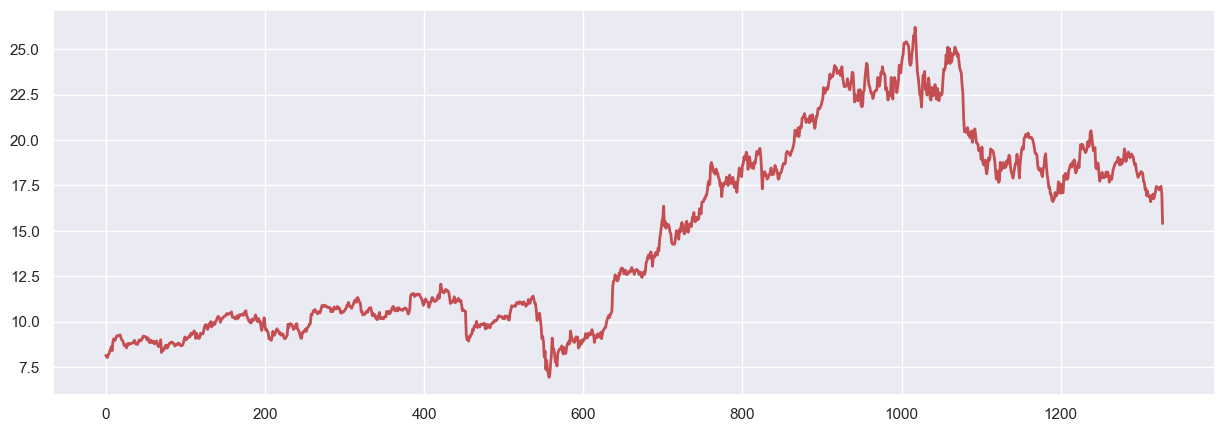

In [9]:
fig = plt.figure(figsize = (15,5))
plt.plot(close, color='r', lw=2.)
plt.plot(close, '^', markersize=10, color='m', label = 'buying signal', markevery = states_buy)
plt.plot(close, 'v', markersize=10, color='k', label = 'selling signal', markevery = states_sell)
plt.title('total gains %f, total investment %f%%'%(total_gains, invest))
plt.legend()
plt.savefig(name+'.png')
plt.show()